# Trabajo Práctico Integrador - Visión por Computadora II
Carrera de Especialización en Inteligencia Artificial - FIUBA

**Integrantes:**
- Juan Ruiz Otondo
- Gonzalo Fernández
- Maria Fabiana Cid

**Objetivo:** Realizar un modelo para la clasificación de residuos para reciclaje basándose en el dataset [TrashNet](https://www.kaggle.com/datasets/feyzazkefe/trashnet).

## Requerimientos
Requisitos para la correcta ejecución del notebook:

- Entorno virtual de python con paquetes instalados, posible mediante la ejecución de los siguientes comandos:

```bash
python -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

- Credenciales de kaggle para descarga del dataset. Más información en el README del siguiente repositorio: https://github.com/Kaggle/kagglehub

In [2]:
from collections import Counter
import copy
import os

import kagglehub
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from PIL import Image
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets, models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Baseline para clasificador
Para el baseline del proyecto se seleccionó una arquitectura ResNet18. La selección fue motivada por las siguientes características: 
- Es ligero y se entrena rápidamente.
- Tiene un buen rendimiento en conjuntos de datos pequeños y medianos.
- Está disponible directamente a través de torchvision.models.
- Admite aprendizaje por transferencia.

### Carga y preprocesamiento del dataset

Carga y preprocesamiento del dataset TrashNet. Más información sobre el EDA del dataset en [02-trashnet-baseline.ipynb](./02-trashnet-baseline.ipynb)

In [ ]:
dataset_path = kagglehub.dataset_download("feyzazkefe/trashnet", force_download=True)
print("Path to dataset files:", dataset_path)
dataset_path = os.path.join(dataset_path, "dataset-resized")

full_dataset = datasets.ImageFolder(root=dataset_path)
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")

Path to dataset files: /home/ggf/.cache/kagglehub/datasets/feyzazkefe/trashnet/versions/1
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


En el EDA se detectó un desbalance de clases (la clase "trash" no esta tan representada como el resto). Se corrige mediante la aplicación de data augmentation.

Con este objetivo, definimos una clase que hereda de la clase base dataset para metermitir aplicaciones orientadas para cada clase.

In [9]:
class ClassAugmentDataset(Dataset):
    # def __init__(self, samples, class_transforms, default_transform):
    def __init__(self, samples, default_transform):
        self.samples = samples
        # self.class_transforms = class_transforms
        self.default_transform = default_transform

    def __getitem__(self, index):
        image, label = self.samples[index]
        # transform = self.class_transforms.get(label, self.default_transform)
        transform = self.default_transform
        return transform(image), label

    def __len__(self):
        return len(self.samples)

Definimos la una transformación para la clase "trash" con data augmentation y otra default. Para validación no se aplica ningun tipo de data augmentation.

In [7]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

Creamos un sampler para los datos de entrenamiento y definimos las transformaciones por clase.

In [8]:
class_counts = Counter([label for _, label in full_dataset.samples])
print("Class counts:", class_counts)

class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
sample_weights = [class_weights[label] for _, label in full_dataset.samples]

Class counts: Counter({3: 594, 1: 501, 4: 482, 2: 410, 0: 403, 5: 137})


1. División del dataset en datos para entrenamiento y datos de validación.
2. Aplicación de transformaciones definidas previamente.
3. Creación de sampler para datos de training
4. Creación de data loaders.

In [12]:
train_samples, val_samples = torch.utils.data.random_split(full_dataset, [0.8, 0.2])

train_dataset = ClassAugmentDataset(train_samples, default_transform=train_transform)
val_dataset = ClassAugmentDataset(val_samples, default_transform=test_transform)

train_labels = [label for _, label in train_samples]
class_counts = Counter(train_labels)
class_weights = {cls: len(train_labels) / count for cls, count in class_counts.items()}
sample_weights = [class_weights[lbl] for lbl in train_labels]
train_sampler = WeightedRandomSampler(
    sample_weights, num_samples=len(sample_weights), replacement=True
)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4)
train_loader_augmented = DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

Se realiza un breve chequeo para comprobar la correcta aplicación del data augmentation.

In [14]:
label_counter = Counter()
for _, labels in train_loader_augmented:
    label_counter.update(labels.tolist())

for cls_idx, count in label_counter.items():
    print(f"Class '{class_names[cls_idx]}': {count} samples")

Class 'metal': 377 samples
Class 'glass': 332 samples
Class 'trash': 318 samples
Class 'paper': 332 samples
Class 'cardboard': 331 samples
Class 'plastic': 332 samples


In [13]:
label_counter = Counter()
for _, labels in train_loader:
    label_counter.update(labels.tolist())

for cls_idx, count in label_counter.items():
    print(f"Class '{class_names[cls_idx]}': {count} samples")

Class 'glass': 401 samples
Class 'cardboard': 297 samples
Class 'paper': 480 samples
Class 'plastic': 403 samples
Class 'metal': 325 samples
Class 'trash': 116 samples


### Definición del modelo baseline
A continuación se carga el modelo pre-entrenado ResNet18 y se congelan las capas previas:

In [15]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

/home/ggf/workspace/ceia/ceia-vpc2/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ggf/workspace/ceia/ceia-vpc2/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Entrenamiento y validación del modelo baseline

Definición del esquema de entrenamiento y validación.

In [16]:
def train_validate(
    model, train_loader, val_loader, criterion, optimizer, device, epochs=10
):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        preds, targets = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = accuracy_score(targets, preds)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        val_loss = 0.0
        val_preds, val_targets = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        if val_acc > best_acc: # save the best model
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print(f"Best accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

### Entrenamiento y validation sin data augmentation
Ejecución del entrenamiento y validación:

In [ ]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_validate(
    model, train_loader, val_loader, criterion, optimizer, device, epochs=10
)

Visualización de resultados:

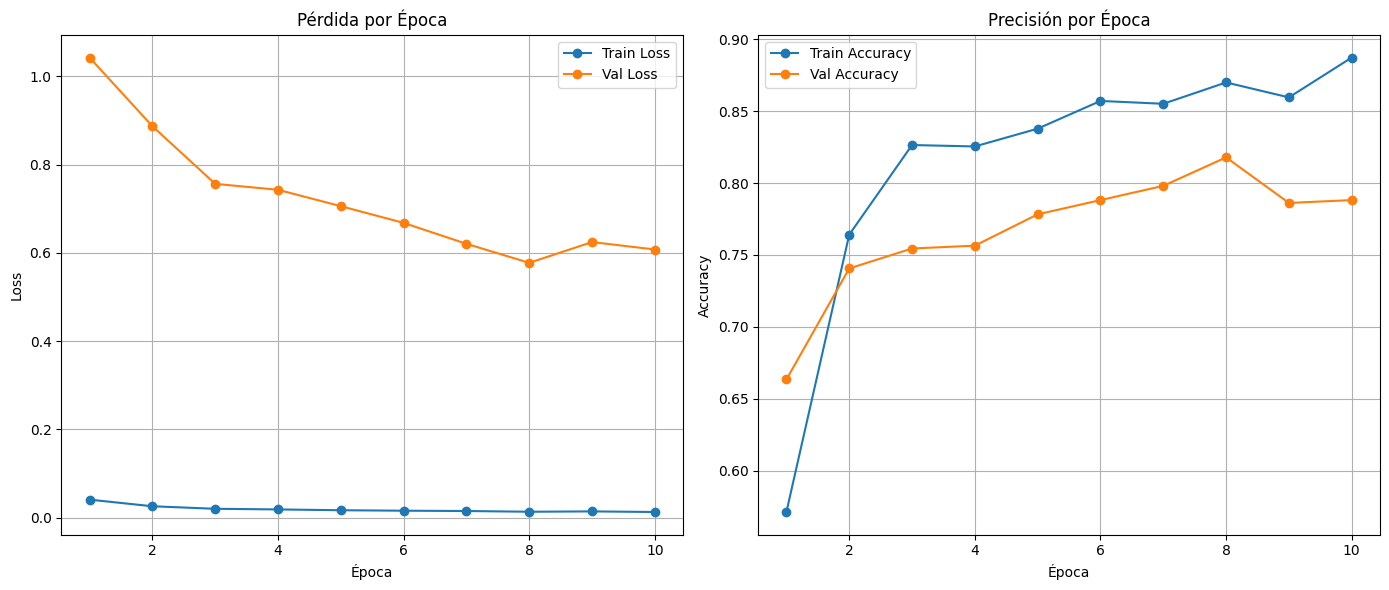

In [ ]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", marker="o")
plt.plot(epochs_range, val_losses, label="Val Loss", marker="o")
plt.title("Pérdida por Época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(epochs_range, val_accuracies, label="Val Accuracy", marker="o")
plt.title("Precisión por Época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Entrenamiento y validation con data augmentation
Ejecución del entrenamiento y validación:

In [ ]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_validate(
    model, train_loader_augmented, val_loader, criterion, optimizer, device, epochs=10
)

Visualización de resultados:

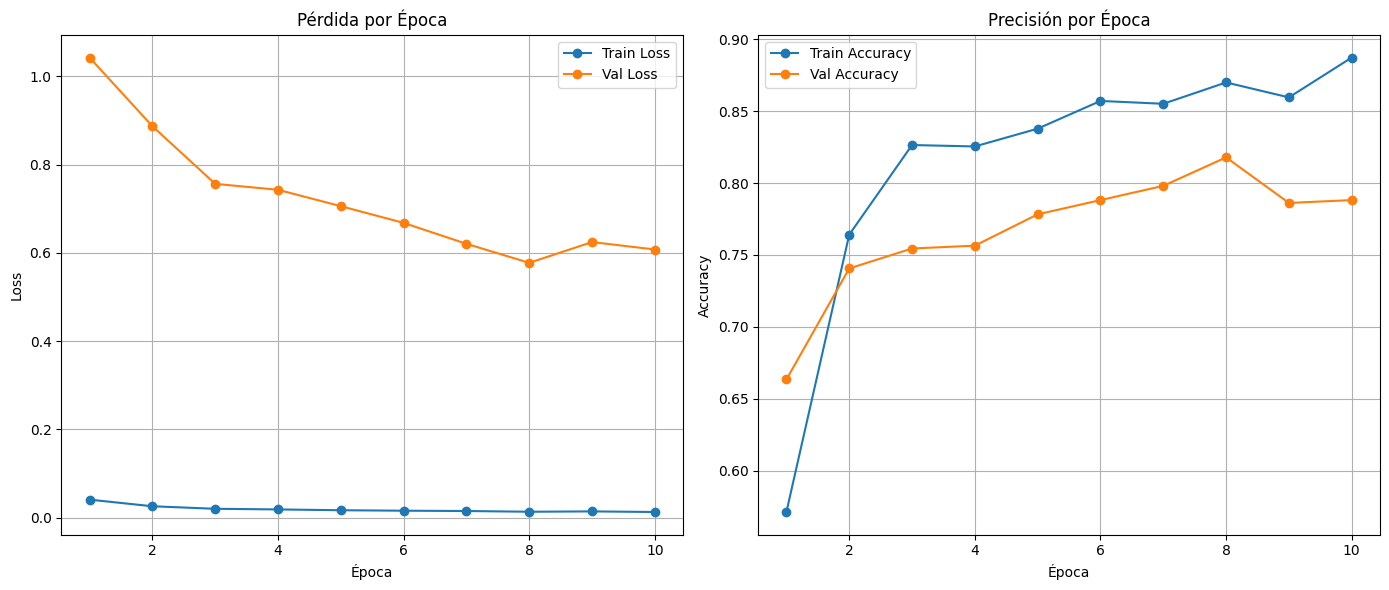

In [ ]:
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", marker="o")
plt.plot(epochs_range, val_losses, label="Val Loss", marker="o")
plt.title("Pérdida por Época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(epochs_range, val_accuracies, label="Val Accuracy", marker="o")
plt.title("Precisión por Época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Exportación del modelo entrenado.

In [93]:
torch.save(model.state_dict(), "output/trashnet_baseline_model.pth")